<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[16:12:58] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


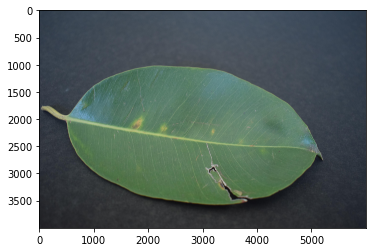

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

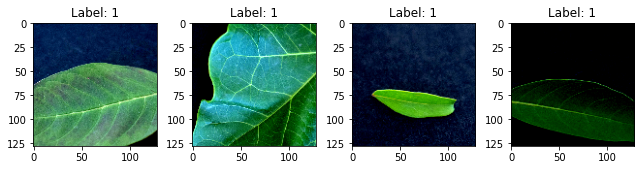

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[16:13:05] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[16:13:07] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2679437386967638 samples/sec                   batch loss = 1.2950246334075928 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2897971722616226 samples/sec                   batch loss = 1.6606343984603882 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.2914434907028736 samples/sec                   batch loss = 0.8294742107391357 | accuracy = 0.48333333333333334


Epoch[1] Batch[20] Speed: 1.2873592570811905 samples/sec                   batch loss = 0.7354590892791748 | accuracy = 0.475


Epoch[1] Batch[25] Speed: 1.2983370093408328 samples/sec                   batch loss = 0.5966985821723938 | accuracy = 0.48


Epoch[1] Batch[30] Speed: 1.2911748408466834 samples/sec                   batch loss = 0.43496498465538025 | accuracy = 0.475


Epoch[1] Batch[35] Speed: 1.3023580473621554 samples/sec                   batch loss = 0.760896623134613 | accuracy = 0.5357142857142857


Epoch[1] Batch[40] Speed: 1.298583519587406 samples/sec                   batch loss = 1.0259051322937012 | accuracy = 0.55625


Epoch[1] Batch[45] Speed: 1.2981482455841709 samples/sec                   batch loss = 0.9724375009536743 | accuracy = 0.55


Epoch[1] Batch[50] Speed: 1.2938043171805624 samples/sec                   batch loss = 1.422298550605774 | accuracy = 0.565


Epoch[1] Batch[55] Speed: 1.2952302603644108 samples/sec                   batch loss = 0.5220065116882324 | accuracy = 0.5727272727272728


Epoch[1] Batch[60] Speed: 1.2984913562082714 samples/sec                   batch loss = 1.0917927026748657 | accuracy = 0.5708333333333333


Epoch[1] Batch[65] Speed: 1.2920042087205657 samples/sec                   batch loss = 0.5187756419181824 | accuracy = 0.5807692307692308


Epoch[1] Batch[70] Speed: 1.2986190014532548 samples/sec                   batch loss = 1.5589423179626465 | accuracy = 0.5964285714285714


Epoch[1] Batch[75] Speed: 1.2882287340184755 samples/sec                   batch loss = 0.7255674004554749 | accuracy = 0.6033333333333334


Epoch[1] Batch[80] Speed: 1.289129002754722 samples/sec                   batch loss = 0.34678915143013 | accuracy = 0.6


Epoch[1] Batch[85] Speed: 1.2978110386083177 samples/sec                   batch loss = 0.3228125274181366 | accuracy = 0.5970588235294118


Epoch[1] Batch[90] Speed: 1.2916378668825605 samples/sec                   batch loss = 0.5841612815856934 | accuracy = 0.5944444444444444


Epoch[1] Batch[95] Speed: 1.2959825521605597 samples/sec                   batch loss = 0.6605257391929626 | accuracy = 0.5973684210526315


Epoch[1] Batch[100] Speed: 1.2922018390667553 samples/sec                   batch loss = 1.2390084266662598 | accuracy = 0.5925


Epoch[1] Batch[105] Speed: 1.297486449147724 samples/sec                   batch loss = 1.0551588535308838 | accuracy = 0.5904761904761905


Epoch[1] Batch[110] Speed: 1.2962380838143848 samples/sec                   batch loss = 1.2370409965515137 | accuracy = 0.5863636363636363


Epoch[1] Batch[115] Speed: 1.2999386339546388 samples/sec                   batch loss = 0.6817450523376465 | accuracy = 0.5847826086956521


Epoch[1] Batch[120] Speed: 1.2946543509533803 samples/sec                   batch loss = 0.424964964389801 | accuracy = 0.5916666666666667


Epoch[1] Batch[125] Speed: 1.3006204787604752 samples/sec                   batch loss = 0.50531405210495 | accuracy = 0.594


Epoch[1] Batch[130] Speed: 1.295563126016043 samples/sec                   batch loss = 0.26104655861854553 | accuracy = 0.6076923076923076


Epoch[1] Batch[135] Speed: 1.2974144070922655 samples/sec                   batch loss = 0.24441096186637878 | accuracy = 0.6148148148148148


Epoch[1] Batch[140] Speed: 1.2990426217078943 samples/sec                   batch loss = 0.4648120403289795 | accuracy = 0.6125


Epoch[1] Batch[145] Speed: 1.3026557467676665 samples/sec                   batch loss = 0.6368024945259094 | accuracy = 0.6068965517241379


Epoch[1] Batch[150] Speed: 1.2976468165947532 samples/sec                   batch loss = 0.5844833850860596 | accuracy = 0.6116666666666667


Epoch[1] Batch[155] Speed: 1.292123416568464 samples/sec                   batch loss = 0.289729505777359 | accuracy = 0.6161290322580645


Epoch[1] Batch[160] Speed: 1.3011545824178952 samples/sec                   batch loss = 2.2392592430114746 | accuracy = 0.6203125


Epoch[1] Batch[165] Speed: 1.298625836709637 samples/sec                   batch loss = 0.6533693075180054 | accuracy = 0.6212121212121212


Epoch[1] Batch[170] Speed: 1.2973872178110868 samples/sec                   batch loss = 0.4086335301399231 | accuracy = 0.625


Epoch[1] Batch[175] Speed: 1.2946633424772207 samples/sec                   batch loss = 0.4438750147819519 | accuracy = 0.6285714285714286


Epoch[1] Batch[180] Speed: 1.2953540648053194 samples/sec                   batch loss = 0.3767636716365814 | accuracy = 0.6319444444444444


Epoch[1] Batch[185] Speed: 1.2990659575077643 samples/sec                   batch loss = 1.2736634016036987 | accuracy = 0.6324324324324324


Epoch[1] Batch[190] Speed: 1.2974940752374469 samples/sec                   batch loss = 0.584601879119873 | accuracy = 0.6302631578947369


Epoch[1] Batch[195] Speed: 1.3053973443127325 samples/sec                   batch loss = 0.5858840942382812 | accuracy = 0.6269230769230769


Epoch[1] Batch[200] Speed: 1.2980597594972347 samples/sec                   batch loss = 0.7080822587013245 | accuracy = 0.62625


Epoch[1] Batch[205] Speed: 1.2987206330510044 samples/sec                   batch loss = 0.40422752499580383 | accuracy = 0.6280487804878049


Epoch[1] Batch[210] Speed: 1.3019336768121823 samples/sec                   batch loss = 0.588280200958252 | accuracy = 0.6297619047619047


Epoch[1] Batch[215] Speed: 1.2964651629605668 samples/sec                   batch loss = 1.553112506866455 | accuracy = 0.6313953488372093


Epoch[1] Batch[220] Speed: 1.2995703966988843 samples/sec                   batch loss = 0.6901117563247681 | accuracy = 0.6295454545454545


Epoch[1] Batch[225] Speed: 1.2947346796589667 samples/sec                   batch loss = 0.6116310954093933 | accuracy = 0.63


Epoch[1] Batch[230] Speed: 1.297622728841411 samples/sec                   batch loss = 1.3366045951843262 | accuracy = 0.6347826086956522


Epoch[1] Batch[235] Speed: 1.2963749027460896 samples/sec                   batch loss = 0.45964688062667847 | accuracy = 0.6351063829787233


Epoch[1] Batch[240] Speed: 1.3007332142683254 samples/sec                   batch loss = 0.6372676491737366 | accuracy = 0.6364583333333333


Epoch[1] Batch[245] Speed: 1.308511580026304 samples/sec                   batch loss = 0.43117406964302063 | accuracy = 0.6408163265306123


Epoch[1] Batch[250] Speed: 1.2996291878843615 samples/sec                   batch loss = 0.27724945545196533 | accuracy = 0.644


Epoch[1] Batch[255] Speed: 1.2997527271059528 samples/sec                   batch loss = 0.3977244198322296 | accuracy = 0.6470588235294118


Epoch[1] Batch[260] Speed: 1.300380048363873 samples/sec                   batch loss = 0.6280266642570496 | accuracy = 0.6490384615384616


Epoch[1] Batch[265] Speed: 1.2925353404905038 samples/sec                   batch loss = 0.43680667877197266 | accuracy = 0.6509433962264151


Epoch[1] Batch[270] Speed: 1.2945431660968472 samples/sec                   batch loss = 1.5273710489273071 | accuracy = 0.6509259259259259


Epoch[1] Batch[275] Speed: 1.2981624084955075 samples/sec                   batch loss = 1.1157608032226562 | accuracy = 0.6509090909090909


Epoch[1] Batch[280] Speed: 1.3038266278738488 samples/sec                   batch loss = 0.32450440526008606 | accuracy = 0.6508928571428572


Epoch[1] Batch[285] Speed: 1.2998980441191044 samples/sec                   batch loss = 0.38803914189338684 | accuracy = 0.6526315789473685


Epoch[1] Batch[290] Speed: 1.3015323004630515 samples/sec                   batch loss = 0.4965119957923889 | accuracy = 0.6551724137931034


Epoch[1] Batch[295] Speed: 1.302766306363796 samples/sec                   batch loss = 0.4543024003505707 | accuracy = 0.6576271186440678


Epoch[1] Batch[300] Speed: 1.2949455399707501 samples/sec                   batch loss = 0.4127276837825775 | accuracy = 0.6566666666666666


Epoch[1] Batch[305] Speed: 1.299625764964037 samples/sec                   batch loss = 0.5107582807540894 | accuracy = 0.6573770491803279


Epoch[1] Batch[310] Speed: 1.290488070811708 samples/sec                   batch loss = 0.4541316330432892 | accuracy = 0.6580645161290323


Epoch[1] Batch[315] Speed: 1.2875772079742343 samples/sec                   batch loss = 0.4267188012599945 | accuracy = 0.6603174603174603


Epoch[1] Batch[320] Speed: 1.282488324017952 samples/sec                   batch loss = 0.19884853065013885 | accuracy = 0.6609375


Epoch[1] Batch[325] Speed: 1.2848411904811319 samples/sec                   batch loss = 0.5578688979148865 | accuracy = 0.6607692307692308


Epoch[1] Batch[330] Speed: 1.2870263476838082 samples/sec                   batch loss = 0.316551148891449 | accuracy = 0.6621212121212121


Epoch[1] Batch[335] Speed: 1.2966465228031256 samples/sec                   batch loss = 0.4406246840953827 | accuracy = 0.664179104477612


Epoch[1] Batch[340] Speed: 1.2962534068998084 samples/sec                   batch loss = 1.0125422477722168 | accuracy = 0.663235294117647


Epoch[1] Batch[345] Speed: 1.2973291308772266 samples/sec                   batch loss = 0.19541355967521667 | accuracy = 0.6666666666666666


Epoch[1] Batch[350] Speed: 1.298347257800063 samples/sec                   batch loss = 0.5142884254455566 | accuracy = 0.6678571428571428


Epoch[1] Batch[355] Speed: 1.2975565924840755 samples/sec                   batch loss = 1.4928150177001953 | accuracy = 0.6683098591549296


Epoch[1] Batch[360] Speed: 1.3009596518494722 samples/sec                   batch loss = 0.40727025270462036 | accuracy = 0.66875


Epoch[1] Batch[365] Speed: 1.2982419676133155 samples/sec                   batch loss = 0.5709487795829773 | accuracy = 0.6705479452054794


Epoch[1] Batch[370] Speed: 1.298307872448485 samples/sec                   batch loss = 0.6825109124183655 | accuracy = 0.6716216216216216


Epoch[1] Batch[375] Speed: 1.3017587133572288 samples/sec                   batch loss = 0.9861735701560974 | accuracy = 0.6726666666666666


Epoch[1] Batch[380] Speed: 1.2999528359597177 samples/sec                   batch loss = 0.46283161640167236 | accuracy = 0.6717105263157894


Epoch[1] Batch[385] Speed: 1.294093027715233 samples/sec                   batch loss = 1.0019457340240479 | accuracy = 0.6727272727272727


Epoch[1] Batch[390] Speed: 1.2957745565116718 samples/sec                   batch loss = 0.24042941629886627 | accuracy = 0.6711538461538461


Epoch[1] Batch[395] Speed: 1.295141371773044 samples/sec                   batch loss = 0.390822172164917 | accuracy = 0.6721518987341772


Epoch[1] Batch[400] Speed: 1.2966458213137326 samples/sec                   batch loss = 0.1996815800666809 | accuracy = 0.675


Epoch[1] Batch[405] Speed: 1.2964207826163625 samples/sec                   batch loss = 0.6344026923179626 | accuracy = 0.6753086419753086


Epoch[1] Batch[410] Speed: 1.2972476774794763 samples/sec                   batch loss = 0.5455235242843628 | accuracy = 0.677439024390244


Epoch[1] Batch[415] Speed: 1.2984884417673703 samples/sec                   batch loss = 0.8424577713012695 | accuracy = 0.6783132530120481


Epoch[1] Batch[420] Speed: 1.2995400971548052 samples/sec                   batch loss = 0.307798832654953 | accuracy = 0.6803571428571429


Epoch[1] Batch[425] Speed: 1.2956499712716467 samples/sec                   batch loss = 0.3872566819190979 | accuracy = 0.68


Epoch[1] Batch[430] Speed: 1.2986021146577293 samples/sec                   batch loss = 0.6205866932868958 | accuracy = 0.6790697674418604


Epoch[1] Batch[435] Speed: 1.2922793752340622 samples/sec                   batch loss = 0.14926180243492126 | accuracy = 0.6810344827586207


Epoch[1] Batch[440] Speed: 1.2974133034461164 samples/sec                   batch loss = 0.4267522990703583 | accuracy = 0.6801136363636363


Epoch[1] Batch[445] Speed: 1.2993367945726726 samples/sec                   batch loss = 0.4217452108860016 | accuracy = 0.6775280898876405


Epoch[1] Batch[450] Speed: 1.296386923358842 samples/sec                   batch loss = 0.4166069030761719 | accuracy = 0.6788888888888889


Epoch[1] Batch[455] Speed: 1.3009047751050182 samples/sec                   batch loss = 0.2585097849369049 | accuracy = 0.6796703296703297


Epoch[1] Batch[460] Speed: 1.298359917884842 samples/sec                   batch loss = 0.5393868088722229 | accuracy = 0.6809782608695653


Epoch[1] Batch[465] Speed: 1.2949823226421158 samples/sec                   batch loss = 0.6189806461334229 | accuracy = 0.6806451612903226


Epoch[1] Batch[470] Speed: 1.2950741884932786 samples/sec                   batch loss = 0.3481687307357788 | accuracy = 0.6829787234042554


Epoch[1] Batch[475] Speed: 1.291126946843071 samples/sec                   batch loss = 3.089052677154541 | accuracy = 0.6826315789473684


Epoch[1] Batch[480] Speed: 1.293418207365643 samples/sec                   batch loss = 1.105402946472168 | accuracy = 0.6817708333333333


Epoch[1] Batch[485] Speed: 1.2966906179454663 samples/sec                   batch loss = 0.48842954635620117 | accuracy = 0.681958762886598


Epoch[1] Batch[490] Speed: 1.298516481241334 samples/sec                   batch loss = 0.554134726524353 | accuracy = 0.6836734693877551


Epoch[1] Batch[495] Speed: 1.2968223199286026 samples/sec                   batch loss = 0.39523643255233765 | accuracy = 0.6848484848484848


Epoch[1] Batch[500] Speed: 1.2932513069362996 samples/sec                   batch loss = 0.4054314196109772 | accuracy = 0.686


Epoch[1] Batch[505] Speed: 1.2949623318006298 samples/sec                   batch loss = 0.85956209897995 | accuracy = 0.6861386138613862


Epoch[1] Batch[510] Speed: 1.2942024380556187 samples/sec                   batch loss = 0.16573628783226013 | accuracy = 0.6862745098039216


Epoch[1] Batch[515] Speed: 1.2992059899153114 samples/sec                   batch loss = 0.6699570417404175 | accuracy = 0.6849514563106797


Epoch[1] Batch[520] Speed: 1.297615201601885 samples/sec                   batch loss = 0.6315433382987976 | accuracy = 0.6831730769230769


Epoch[1] Batch[525] Speed: 1.2987899044518805 samples/sec                   batch loss = 0.8272098898887634 | accuracy = 0.6838095238095238


Epoch[1] Batch[530] Speed: 1.2951338732935826 samples/sec                   batch loss = 0.3040275275707245 | accuracy = 0.684433962264151


Epoch[1] Batch[535] Speed: 1.2998462781309819 samples/sec                   batch loss = 0.8616998195648193 | accuracy = 0.6845794392523364


Epoch[1] Batch[540] Speed: 1.2941524224567613 samples/sec                   batch loss = 0.2944677174091339 | accuracy = 0.6847222222222222


Epoch[1] Batch[545] Speed: 1.2963116980251532 samples/sec                   batch loss = 0.5957245826721191 | accuracy = 0.6844036697247706


Epoch[1] Batch[550] Speed: 1.2995918387581835 samples/sec                   batch loss = 0.3821577727794647 | accuracy = 0.6854545454545454


Epoch[1] Batch[555] Speed: 1.2923740436828666 samples/sec                   batch loss = 0.553935706615448 | accuracy = 0.6851351351351351


Epoch[1] Batch[560] Speed: 1.3042339832652539 samples/sec                   batch loss = 0.2882418632507324 | accuracy = 0.6857142857142857


Epoch[1] Batch[565] Speed: 1.2983333922762037 samples/sec                   batch loss = 0.45666635036468506 | accuracy = 0.6853982300884955


Epoch[1] Batch[570] Speed: 1.2952184611764481 samples/sec                   batch loss = 0.3808976113796234 | accuracy = 0.6872807017543859


Epoch[1] Batch[575] Speed: 1.2966416123933135 samples/sec                   batch loss = 0.5010579228401184 | accuracy = 0.6869565217391305


Epoch[1] Batch[580] Speed: 1.2888166615261645 samples/sec                   batch loss = 0.3396170437335968 | accuracy = 0.6879310344827586


Epoch[1] Batch[585] Speed: 1.2898709492157814 samples/sec                   batch loss = 0.4945957660675049 | accuracy = 0.6897435897435897


Epoch[1] Batch[590] Speed: 1.2891779373833505 samples/sec                   batch loss = 0.5584922432899475 | accuracy = 0.6894067796610169


Epoch[1] Batch[595] Speed: 1.2934502164922685 samples/sec                   batch loss = 1.0656646490097046 | accuracy = 0.6899159663865546


Epoch[1] Batch[600] Speed: 1.2935213203138367 samples/sec                   batch loss = 0.8534336686134338 | accuracy = 0.69


Epoch[1] Batch[605] Speed: 1.2983083747976183 samples/sec                   batch loss = 0.6976011991500854 | accuracy = 0.6888429752066115


Epoch[1] Batch[610] Speed: 1.2984430183795002 samples/sec                   batch loss = 0.88941490650177 | accuracy = 0.6889344262295082


Epoch[1] Batch[615] Speed: 1.2996726806773147 samples/sec                   batch loss = 0.649250328540802 | accuracy = 0.6890243902439024


Epoch[1] Batch[620] Speed: 1.291129828332043 samples/sec                   batch loss = 0.612119197845459 | accuracy = 0.6883064516129033


Epoch[1] Batch[625] Speed: 1.2916311049897722 samples/sec                   batch loss = 0.41087743639945984 | accuracy = 0.6888


Epoch[1] Batch[630] Speed: 1.2905322444295215 samples/sec                   batch loss = 0.619035005569458 | accuracy = 0.6896825396825397


Epoch[1] Batch[635] Speed: 1.2882328884993006 samples/sec                   batch loss = 1.156517744064331 | accuracy = 0.6874015748031496


Epoch[1] Batch[640] Speed: 1.2884588534806833 samples/sec                   batch loss = 0.4687235951423645 | accuracy = 0.687890625


Epoch[1] Batch[645] Speed: 1.2888348789242912 samples/sec                   batch loss = 0.4249080419540405 | accuracy = 0.6891472868217055


Epoch[1] Batch[650] Speed: 1.2895440743687718 samples/sec                   batch loss = 0.4779259264469147 | accuracy = 0.6892307692307692


Epoch[1] Batch[655] Speed: 1.2857357437445243 samples/sec                   batch loss = 0.3744439482688904 | accuracy = 0.6900763358778625


Epoch[1] Batch[660] Speed: 1.2846887926071733 samples/sec                   batch loss = 0.46426326036453247 | accuracy = 0.6912878787878788


Epoch[1] Batch[665] Speed: 1.2835038032213641 samples/sec                   batch loss = 0.19595253467559814 | accuracy = 0.6909774436090226


Epoch[1] Batch[670] Speed: 1.2953241615649989 samples/sec                   batch loss = 0.5726860761642456 | accuracy = 0.691044776119403


Epoch[1] Batch[675] Speed: 1.29259867542893 samples/sec                   batch loss = 0.45372632145881653 | accuracy = 0.6918518518518518


Epoch[1] Batch[680] Speed: 1.284227785411109 samples/sec                   batch loss = 0.527755081653595 | accuracy = 0.6922794117647059


Epoch[1] Batch[685] Speed: 1.2836151621789424 samples/sec                   batch loss = 0.6171021461486816 | accuracy = 0.6927007299270073


Epoch[1] Batch[690] Speed: 1.2831754362832093 samples/sec                   batch loss = 0.2751319408416748 | accuracy = 0.6931159420289855


Epoch[1] Batch[695] Speed: 1.2844997474980255 samples/sec                   batch loss = 0.4953799247741699 | accuracy = 0.6935251798561151


Epoch[1] Batch[700] Speed: 1.28282193029145 samples/sec                   batch loss = 0.7990483045578003 | accuracy = 0.6939285714285715


Epoch[1] Batch[705] Speed: 1.2892145912592268 samples/sec                   batch loss = 0.6398112773895264 | accuracy = 0.6932624113475178


Epoch[1] Batch[710] Speed: 1.2915727368879957 samples/sec                   batch loss = 0.6375908255577087 | accuracy = 0.694718309859155


Epoch[1] Batch[715] Speed: 1.2847765473290516 samples/sec                   batch loss = 0.4108594059944153 | accuracy = 0.6947552447552447


Epoch[1] Batch[720] Speed: 1.2892874098713096 samples/sec                   batch loss = 0.7503101825714111 | accuracy = 0.6951388888888889


Epoch[1] Batch[725] Speed: 1.288572063638066 samples/sec                   batch loss = 0.8452445268630981 | accuracy = 0.6948275862068966


Epoch[1] Batch[730] Speed: 1.2861053502734923 samples/sec                   batch loss = 0.3866129517555237 | accuracy = 0.6958904109589041


Epoch[1] Batch[735] Speed: 1.2860450159785797 samples/sec                   batch loss = 0.5051161646842957 | accuracy = 0.6962585034013605


Epoch[1] Batch[740] Speed: 1.288164837522253 samples/sec                   batch loss = 0.8807968497276306 | accuracy = 0.6956081081081081


Epoch[1] Batch[745] Speed: 1.2882640479596323 samples/sec                   batch loss = 0.5630936026573181 | accuracy = 0.6973154362416107


Epoch[1] Batch[750] Speed: 1.2908918010844213 samples/sec                   batch loss = 0.9273558259010315 | accuracy = 0.697


Epoch[1] Batch[755] Speed: 1.286794963056797 samples/sec                   batch loss = 0.7754338979721069 | accuracy = 0.697682119205298


Epoch[1] Batch[760] Speed: 1.288892900809072 samples/sec                   batch loss = 0.36802566051483154 | accuracy = 0.6980263157894737


Epoch[1] Batch[765] Speed: 1.2821524415836034 samples/sec                   batch loss = 0.3926750123500824 | accuracy = 0.6990196078431372


Epoch[1] Batch[770] Speed: 1.284107474516034 samples/sec                   batch loss = 0.3180426061153412 | accuracy = 0.6996753246753247


Epoch[1] Batch[775] Speed: 1.2882874927377825 samples/sec                   batch loss = 0.6479045152664185 | accuracy = 0.7006451612903226


Epoch[1] Batch[780] Speed: 1.2905786051638017 samples/sec                   batch loss = 0.8629893064498901 | accuracy = 0.6990384615384615


Epoch[1] Batch[785] Speed: 1.2895398123093087 samples/sec                   batch loss = 0.4750237464904785 | accuracy = 0.6984076433121019


[Epoch 1] training: accuracy=0.6986040609137056
[Epoch 1] time cost: 635.8133716583252
[Epoch 1] validation: validation accuracy=0.7288888888888889


Epoch[2] Batch[5] Speed: 1.2973146851935593 samples/sec                   batch loss = 0.9586570262908936 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.295187364346561 samples/sec                   batch loss = 0.564927339553833 | accuracy = 0.65


Epoch[2] Batch[15] Speed: 1.293904897170706 samples/sec                   batch loss = 0.4768928289413452 | accuracy = 0.6833333333333333


Epoch[2] Batch[20] Speed: 1.29951563709179 samples/sec                   batch loss = 0.6394836902618408 | accuracy = 0.675


Epoch[2] Batch[25] Speed: 1.2975963337052747 samples/sec                   batch loss = 0.3488087058067322 | accuracy = 0.66


Epoch[2] Batch[30] Speed: 1.3013385689229737 samples/sec                   batch loss = 1.1667895317077637 | accuracy = 0.6333333333333333


Epoch[2] Batch[35] Speed: 1.3025530938634367 samples/sec                   batch loss = 0.3061060607433319 | accuracy = 0.65


Epoch[2] Batch[40] Speed: 1.3001281202925015 samples/sec                   batch loss = 0.3452286422252655 | accuracy = 0.68125


Epoch[2] Batch[45] Speed: 1.2978381452594592 samples/sec                   batch loss = 0.28958871960639954 | accuracy = 0.7


Epoch[2] Batch[50] Speed: 1.297608577703339 samples/sec                   batch loss = 0.362528920173645 | accuracy = 0.715


Epoch[2] Batch[55] Speed: 1.3015577452627423 samples/sec                   batch loss = 0.1692734956741333 | accuracy = 0.7181818181818181


Epoch[2] Batch[60] Speed: 1.2950328022637656 samples/sec                   batch loss = 0.569263219833374 | accuracy = 0.7208333333333333


Epoch[2] Batch[65] Speed: 1.2977112557308332 samples/sec                   batch loss = 0.22840476036071777 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.3060867592595549 samples/sec                   batch loss = 0.5355263352394104 | accuracy = 0.7357142857142858


Epoch[2] Batch[75] Speed: 1.297795879456373 samples/sec                   batch loss = 0.741685152053833 | accuracy = 0.7333333333333333


Epoch[2] Batch[80] Speed: 1.2995223811324514 samples/sec                   batch loss = 0.7447853684425354 | accuracy = 0.728125


Epoch[2] Batch[85] Speed: 1.2987310886380103 samples/sec                   batch loss = 0.42290812730789185 | accuracy = 0.7235294117647059


Epoch[2] Batch[90] Speed: 1.29672268902367 samples/sec                   batch loss = 0.8886741995811462 | accuracy = 0.725


Epoch[2] Batch[95] Speed: 1.2961745920138843 samples/sec                   batch loss = 0.3154366612434387 | accuracy = 0.7315789473684211


Epoch[2] Batch[100] Speed: 1.2940781549276306 samples/sec                   batch loss = 0.503583550453186 | accuracy = 0.7375


Epoch[2] Batch[105] Speed: 1.3035351788746263 samples/sec                   batch loss = 0.6193283200263977 | accuracy = 0.7380952380952381


Epoch[2] Batch[110] Speed: 1.2990196890662153 samples/sec                   batch loss = 0.4089365303516388 | accuracy = 0.7340909090909091


Epoch[2] Batch[115] Speed: 1.3007801091208422 samples/sec                   batch loss = 0.5668998956680298 | accuracy = 0.7391304347826086


Epoch[2] Batch[120] Speed: 1.3011051379768677 samples/sec                   batch loss = 0.5128217339515686 | accuracy = 0.7270833333333333


Epoch[2] Batch[125] Speed: 1.3030180435813032 samples/sec                   batch loss = 0.32724714279174805 | accuracy = 0.728


Epoch[2] Batch[130] Speed: 1.2986538821177733 samples/sec                   batch loss = 0.4872976541519165 | accuracy = 0.7307692307692307


Epoch[2] Batch[135] Speed: 1.2983736834952881 samples/sec                   batch loss = 0.4569292366504669 | accuracy = 0.7296296296296296


Epoch[2] Batch[140] Speed: 1.2983773007844182 samples/sec                   batch loss = 0.2889402210712433 | accuracy = 0.7321428571428571


Epoch[2] Batch[145] Speed: 1.2967449392662482 samples/sec                   batch loss = 0.1976575255393982 | accuracy = 0.7310344827586207


Epoch[2] Batch[150] Speed: 1.293782766359891 samples/sec                   batch loss = 0.4907377362251282 | accuracy = 0.725


Epoch[2] Batch[155] Speed: 1.2964466290387477 samples/sec                   batch loss = 0.2663789987564087 | accuracy = 0.7225806451612903


Epoch[2] Batch[160] Speed: 1.2999237272192792 samples/sec                   batch loss = 0.5800662040710449 | accuracy = 0.725


Epoch[2] Batch[165] Speed: 1.2968733440960247 samples/sec                   batch loss = 0.5280678868293762 | accuracy = 0.7257575757575757


Epoch[2] Batch[170] Speed: 1.2997848491367974 samples/sec                   batch loss = 0.7048293352127075 | accuracy = 0.7323529411764705


Epoch[2] Batch[175] Speed: 1.299843659727516 samples/sec                   batch loss = 0.3376431167125702 | accuracy = 0.7357142857142858


Epoch[2] Batch[180] Speed: 1.2947951325837865 samples/sec                   batch loss = 0.7672074437141418 | accuracy = 0.7388888888888889


Epoch[2] Batch[185] Speed: 1.2988778867667439 samples/sec                   batch loss = 0.09169226139783859 | accuracy = 0.7418918918918919


Epoch[2] Batch[190] Speed: 1.2978720803669301 samples/sec                   batch loss = 0.3940522372722626 | accuracy = 0.7460526315789474


Epoch[2] Batch[195] Speed: 1.2958809482541016 samples/sec                   batch loss = 0.33464428782463074 | accuracy = 0.7461538461538462


Epoch[2] Batch[200] Speed: 1.2871569824893052 samples/sec                   batch loss = 0.25596779584884644 | accuracy = 0.7475


Epoch[2] Batch[205] Speed: 1.291387127583126 samples/sec                   batch loss = 0.35783281922340393 | accuracy = 0.7463414634146341


Epoch[2] Batch[210] Speed: 1.2880922445514944 samples/sec                   batch loss = 0.32823672890663147 | accuracy = 0.7488095238095238


Epoch[2] Batch[215] Speed: 1.2902602028413352 samples/sec                   batch loss = 0.762754499912262 | accuracy = 0.75


Epoch[2] Batch[220] Speed: 1.2895651868461895 samples/sec                   batch loss = 0.622464120388031 | accuracy = 0.7454545454545455


Epoch[2] Batch[225] Speed: 1.2896788889271535 samples/sec                   batch loss = 0.2384941726922989 | accuracy = 0.7466666666666667


Epoch[2] Batch[230] Speed: 1.2945107033214416 samples/sec                   batch loss = 0.486611932516098 | accuracy = 0.7467391304347826


Epoch[2] Batch[235] Speed: 1.288568599745577 samples/sec                   batch loss = 0.4586285352706909 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.2891724890121687 samples/sec                   batch loss = 0.706765353679657 | accuracy = 0.7479166666666667


Epoch[2] Batch[245] Speed: 1.2881791790633537 samples/sec                   batch loss = 0.26395484805107117 | accuracy = 0.75


Epoch[2] Batch[250] Speed: 1.2913934893115222 samples/sec                   batch loss = 0.2188449651002884 | accuracy = 0.749


Epoch[2] Batch[255] Speed: 1.290079236158663 samples/sec                   batch loss = 0.4937450587749481 | accuracy = 0.7490196078431373


Epoch[2] Batch[260] Speed: 1.2869763915708543 samples/sec                   batch loss = 0.6315683722496033 | accuracy = 0.7490384615384615


Epoch[2] Batch[265] Speed: 1.2875828405030265 samples/sec                   batch loss = 0.7535263299942017 | accuracy = 0.7481132075471698


Epoch[2] Batch[270] Speed: 1.2887111295599274 samples/sec                   batch loss = 0.3016410768032074 | accuracy = 0.7490740740740741


Epoch[2] Batch[275] Speed: 1.2988168509117264 samples/sec                   batch loss = 0.40802115201950073 | accuracy = 0.7490909090909091


Epoch[2] Batch[280] Speed: 1.289078883281891 samples/sec                   batch loss = 0.13891661167144775 | accuracy = 0.7508928571428571


Epoch[2] Batch[285] Speed: 1.297994984482595 samples/sec                   batch loss = 0.3326683044433594 | accuracy = 0.7543859649122807


Epoch[2] Batch[290] Speed: 1.297280478294976 samples/sec                   batch loss = 0.17728346586227417 | accuracy = 0.7560344827586207


Epoch[2] Batch[295] Speed: 1.2957493373243063 samples/sec                   batch loss = 0.43435657024383545 | accuracy = 0.7593220338983051


Epoch[2] Batch[300] Speed: 1.297638686878023 samples/sec                   batch loss = 0.4899712800979614 | accuracy = 0.76


Epoch[2] Batch[305] Speed: 1.2982751201239184 samples/sec                   batch loss = 0.17185543477535248 | accuracy = 0.7598360655737705


Epoch[2] Batch[310] Speed: 1.3021391067457808 samples/sec                   batch loss = 0.5768629312515259 | accuracy = 0.7596774193548387


Epoch[2] Batch[315] Speed: 1.295231860270855 samples/sec                   batch loss = 0.4947708547115326 | accuracy = 0.7595238095238095


Epoch[2] Batch[320] Speed: 1.2914874315034353 samples/sec                   batch loss = 1.0295995473861694 | accuracy = 0.7578125


Epoch[2] Batch[325] Speed: 1.2943866605747876 samples/sec                   batch loss = 1.1251074075698853 | accuracy = 0.7584615384615384


Epoch[2] Batch[330] Speed: 1.2903006891795101 samples/sec                   batch loss = 0.34346309304237366 | accuracy = 0.759090909090909


Epoch[2] Batch[335] Speed: 1.2861036742444132 samples/sec                   batch loss = 0.36180514097213745 | accuracy = 0.7597014925373134


Epoch[2] Batch[340] Speed: 1.2943306393982015 samples/sec                   batch loss = 0.6107707619667053 | accuracy = 0.7573529411764706


Epoch[2] Batch[345] Speed: 1.2896913805262413 samples/sec                   batch loss = 0.2973616421222687 | accuracy = 0.7579710144927536


Epoch[2] Batch[350] Speed: 1.293109066799935 samples/sec                   batch loss = 0.3853692412376404 | accuracy = 0.7578571428571429


Epoch[2] Batch[355] Speed: 1.291291609791277 samples/sec                   batch loss = 0.3978605568408966 | accuracy = 0.7584507042253521


Epoch[2] Batch[360] Speed: 1.2920424165202482 samples/sec                   batch loss = 0.15925395488739014 | accuracy = 0.7597222222222222


Epoch[2] Batch[365] Speed: 1.2960065790586666 samples/sec                   batch loss = 0.3409574627876282 | accuracy = 0.7616438356164383


Epoch[2] Batch[370] Speed: 1.2973324413917104 samples/sec                   batch loss = 0.23986554145812988 | accuracy = 0.7635135135135135


Epoch[2] Batch[375] Speed: 1.2974398918074186 samples/sec                   batch loss = 0.4589017927646637 | accuracy = 0.7626666666666667


Epoch[2] Batch[380] Speed: 1.295443682783847 samples/sec                   batch loss = 0.34562018513679504 | accuracy = 0.7611842105263158


Epoch[2] Batch[385] Speed: 1.2940989170343402 samples/sec                   batch loss = 0.11746536195278168 | accuracy = 0.7623376623376623


Epoch[2] Batch[390] Speed: 1.289133955483382 samples/sec                   batch loss = 0.3879767060279846 | accuracy = 0.7634615384615384


Epoch[2] Batch[395] Speed: 1.2933854021477154 samples/sec                   batch loss = 0.10595184564590454 | accuracy = 0.7651898734177215


Epoch[2] Batch[400] Speed: 1.2946855221033626 samples/sec                   batch loss = 0.6033620834350586 | accuracy = 0.765


Epoch[2] Batch[405] Speed: 1.2916232493502897 samples/sec                   batch loss = 0.5704168677330017 | accuracy = 0.7641975308641975


Epoch[2] Batch[410] Speed: 1.2911537749965907 samples/sec                   batch loss = 0.603656530380249 | accuracy = 0.7646341463414634


Epoch[2] Batch[415] Speed: 1.2922643450317555 samples/sec                   batch loss = 0.9407292604446411 | accuracy = 0.7614457831325301


Epoch[2] Batch[420] Speed: 1.2936970690431462 samples/sec                   batch loss = 0.64216148853302 | accuracy = 0.7619047619047619


Epoch[2] Batch[425] Speed: 1.2913357390440883 samples/sec                   batch loss = 0.5144296884536743 | accuracy = 0.7617647058823529


Epoch[2] Batch[430] Speed: 1.2945868186106362 samples/sec                   batch loss = 0.25716009736061096 | accuracy = 0.7622093023255814


Epoch[2] Batch[435] Speed: 1.2938153921871276 samples/sec                   batch loss = 0.2870136797428131 | accuracy = 0.7637931034482759


Epoch[2] Batch[440] Speed: 1.2964233872478925 samples/sec                   batch loss = 0.2584465742111206 | accuracy = 0.7647727272727273


Epoch[2] Batch[445] Speed: 1.2898963367861598 samples/sec                   batch loss = 0.35619357228279114 | accuracy = 0.7651685393258427


Epoch[2] Batch[450] Speed: 1.2956508718018738 samples/sec                   batch loss = 0.39387190341949463 | accuracy = 0.765


Epoch[2] Batch[455] Speed: 1.2972465741169663 samples/sec                   batch loss = 0.35302814841270447 | accuracy = 0.7675824175824176


Epoch[2] Batch[460] Speed: 1.291544897062264 samples/sec                   batch loss = 0.7176763415336609 | accuracy = 0.7668478260869566


Epoch[2] Batch[465] Speed: 1.2878054142397652 samples/sec                   batch loss = 0.4368125796318054 | accuracy = 0.7682795698924731


Epoch[2] Batch[470] Speed: 1.2920405259770193 samples/sec                   batch loss = 0.2563176155090332 | accuracy = 0.7675531914893617


Epoch[2] Batch[475] Speed: 1.2908050959408908 samples/sec                   batch loss = 0.115387924015522 | accuracy = 0.7668421052631579


Epoch[2] Batch[480] Speed: 1.2879901930678355 samples/sec                   batch loss = 0.1904059499502182 | accuracy = 0.7671875


Epoch[2] Batch[485] Speed: 1.297253695853481 samples/sec                   batch loss = 0.4840516448020935 | accuracy = 0.7680412371134021


Epoch[2] Batch[490] Speed: 1.2922858452963426 samples/sec                   batch loss = 0.5209591388702393 | accuracy = 0.7668367346938776


Epoch[2] Batch[495] Speed: 1.2982775312816475 samples/sec                   batch loss = 0.38768452405929565 | accuracy = 0.7661616161616162


Epoch[2] Batch[500] Speed: 1.2898556774868766 samples/sec                   batch loss = 0.6229734420776367 | accuracy = 0.765


Epoch[2] Batch[505] Speed: 1.2864438990932439 samples/sec                   batch loss = 0.39022135734558105 | accuracy = 0.7643564356435644


Epoch[2] Batch[510] Speed: 1.289014209168425 samples/sec                   batch loss = 0.261777400970459 | accuracy = 0.765686274509804


Epoch[2] Batch[515] Speed: 1.2894566582282139 samples/sec                   batch loss = 0.11671219766139984 | accuracy = 0.7640776699029126


Epoch[2] Batch[520] Speed: 1.2946438610000832 samples/sec                   batch loss = 0.5453706979751587 | accuracy = 0.7644230769230769


Epoch[2] Batch[525] Speed: 1.2920586356184336 samples/sec                   batch loss = 0.22967588901519775 | accuracy = 0.7652380952380953


Epoch[2] Batch[530] Speed: 1.2889061693459698 samples/sec                   batch loss = 0.5070852041244507 | accuracy = 0.7650943396226415


Epoch[2] Batch[535] Speed: 1.2983629322271324 samples/sec                   batch loss = 0.5450875163078308 | accuracy = 0.7658878504672897


Epoch[2] Batch[540] Speed: 1.2889629102759068 samples/sec                   batch loss = 0.5839447379112244 | accuracy = 0.7643518518518518


Epoch[2] Batch[545] Speed: 1.2908501851346323 samples/sec                   batch loss = 0.6124826669692993 | accuracy = 0.7637614678899083


Epoch[2] Batch[550] Speed: 1.2928136223212723 samples/sec                   batch loss = 0.571621298789978 | accuracy = 0.7622727272727273


Epoch[2] Batch[555] Speed: 1.2934565985636395 samples/sec                   batch loss = 0.5672683715820312 | accuracy = 0.763063063063063


Epoch[2] Batch[560] Speed: 1.291326396112755 samples/sec                   batch loss = 0.13911189138889313 | accuracy = 0.7633928571428571


Epoch[2] Batch[565] Speed: 1.2912722296537 samples/sec                   batch loss = 0.38679295778274536 | accuracy = 0.7632743362831859


Epoch[2] Batch[570] Speed: 1.2896887037346374 samples/sec                   batch loss = 0.6574636697769165 | accuracy = 0.7618421052631579


Epoch[2] Batch[575] Speed: 1.2900888586570791 samples/sec                   batch loss = 0.4221717119216919 | accuracy = 0.7617391304347826


Epoch[2] Batch[580] Speed: 1.292773675438387 samples/sec                   batch loss = 0.4630638062953949 | accuracy = 0.7603448275862069


Epoch[2] Batch[585] Speed: 1.2930735864005896 samples/sec                   batch loss = 0.6565365791320801 | accuracy = 0.7611111111111111


Epoch[2] Batch[590] Speed: 1.2950029138541221 samples/sec                   batch loss = 0.3680298924446106 | accuracy = 0.7597457627118644


Epoch[2] Batch[595] Speed: 1.2921413294982664 samples/sec                   batch loss = 0.33362558484077454 | accuracy = 0.7588235294117647


Epoch[2] Batch[600] Speed: 1.2926625145641286 samples/sec                   batch loss = 0.4830433428287506 | accuracy = 0.75875


Epoch[2] Batch[605] Speed: 1.2923135179861274 samples/sec                   batch loss = 0.46264931559562683 | accuracy = 0.7582644628099173


Epoch[2] Batch[610] Speed: 1.2920873931800505 samples/sec                   batch loss = 0.20893917977809906 | accuracy = 0.7577868852459017


Epoch[2] Batch[615] Speed: 1.2909511009992911 samples/sec                   batch loss = 0.39922958612442017 | accuracy = 0.7573170731707317


Epoch[2] Batch[620] Speed: 1.293466770120061 samples/sec                   batch loss = 0.5575014352798462 | accuracy = 0.7576612903225807


Epoch[2] Batch[625] Speed: 1.29809209921081 samples/sec                   batch loss = 0.3162000775337219 | accuracy = 0.7588


Epoch[2] Batch[630] Speed: 1.2930854462050778 samples/sec                   batch loss = 0.19023434817790985 | accuracy = 0.7595238095238095


Epoch[2] Batch[635] Speed: 1.2885859193942548 samples/sec                   batch loss = 0.1987793892621994 | accuracy = 0.7606299212598425


Epoch[2] Batch[640] Speed: 1.288921616643523 samples/sec                   batch loss = 0.1971202939748764 | accuracy = 0.760546875


Epoch[2] Batch[645] Speed: 1.2876389708507066 samples/sec                   batch loss = 0.37188008427619934 | accuracy = 0.7604651162790698


Epoch[2] Batch[650] Speed: 1.2908953768043314 samples/sec                   batch loss = 0.31397390365600586 | accuracy = 0.7615384615384615


Epoch[2] Batch[655] Speed: 1.2927901121361738 samples/sec                   batch loss = 0.3429393768310547 | accuracy = 0.7629770992366413


Epoch[2] Batch[660] Speed: 1.2958755431724065 samples/sec                   batch loss = 0.5421887636184692 | accuracy = 0.7632575757575758


Epoch[2] Batch[665] Speed: 1.2927582352848257 samples/sec                   batch loss = 0.3309638798236847 | accuracy = 0.7635338345864662


Epoch[2] Batch[670] Speed: 1.2887771592635207 samples/sec                   batch loss = 0.4827527403831482 | accuracy = 0.7634328358208955


Epoch[2] Batch[675] Speed: 1.2907382624687889 samples/sec                   batch loss = 1.0571177005767822 | accuracy = 0.7633333333333333


Epoch[2] Batch[680] Speed: 1.2934273811589754 samples/sec                   batch loss = 0.5665633678436279 | accuracy = 0.7628676470588235


Epoch[2] Batch[685] Speed: 1.285782647361501 samples/sec                   batch loss = 0.5836058855056763 | accuracy = 0.7638686131386861


Epoch[2] Batch[690] Speed: 1.2912325767235255 samples/sec                   batch loss = 0.36732980608940125 | accuracy = 0.7641304347826087


Epoch[2] Batch[695] Speed: 1.291537440169877 samples/sec                   batch loss = 0.37951216101646423 | accuracy = 0.7647482014388489


Epoch[2] Batch[700] Speed: 1.2948908695894121 samples/sec                   batch loss = 0.25344032049179077 | accuracy = 0.7653571428571428


Epoch[2] Batch[705] Speed: 1.290316368394924 samples/sec                   batch loss = 0.317482590675354 | accuracy = 0.7652482269503547


Epoch[2] Batch[710] Speed: 1.2932729397472227 samples/sec                   batch loss = 0.41820427775382996 | accuracy = 0.7647887323943662


Epoch[2] Batch[715] Speed: 1.2833791119791804 samples/sec                   batch loss = 0.7331322431564331 | accuracy = 0.7646853146853146


Epoch[2] Batch[720] Speed: 1.2944867318554292 samples/sec                   batch loss = 0.8198361396789551 | accuracy = 0.7642361111111111


Epoch[2] Batch[725] Speed: 1.2851811414103136 samples/sec                   batch loss = 0.5026533603668213 | accuracy = 0.7637931034482759


Epoch[2] Batch[730] Speed: 1.2883889976974097 samples/sec                   batch loss = 0.3373643159866333 | accuracy = 0.7640410958904109


Epoch[2] Batch[735] Speed: 1.2915496695185809 samples/sec                   batch loss = 0.11326613277196884 | accuracy = 0.7646258503401361


Epoch[2] Batch[740] Speed: 1.2937744854484439 samples/sec                   batch loss = 0.2563575208187103 | accuracy = 0.7648648648648648


Epoch[2] Batch[745] Speed: 1.2991796309345889 samples/sec                   batch loss = 0.5613570213317871 | accuracy = 0.7651006711409396


Epoch[2] Batch[750] Speed: 1.301260345592366 samples/sec                   batch loss = 0.2077835202217102 | accuracy = 0.766


Epoch[2] Batch[755] Speed: 1.2967761109352676 samples/sec                   batch loss = 0.1629112958908081 | accuracy = 0.7665562913907285


Epoch[2] Batch[760] Speed: 1.2924943155095394 samples/sec                   batch loss = 0.37825074791908264 | accuracy = 0.7664473684210527


Epoch[2] Batch[765] Speed: 1.2899013945855746 samples/sec                   batch loss = 0.5004971623420715 | accuracy = 0.7660130718954249


Epoch[2] Batch[770] Speed: 1.2967276000475803 samples/sec                   batch loss = 0.46807026863098145 | accuracy = 0.7652597402597403


Epoch[2] Batch[775] Speed: 1.2906163315597363 samples/sec                   batch loss = 0.8373497128486633 | accuracy = 0.7638709677419355


Epoch[2] Batch[780] Speed: 1.3016245930875368 samples/sec                   batch loss = 0.1660277545452118 | accuracy = 0.764102564102564


Epoch[2] Batch[785] Speed: 1.2881792779716426 samples/sec                   batch loss = 0.6901804804801941 | accuracy = 0.7646496815286624


[Epoch 2] training: accuracy=0.7652284263959391
[Epoch 2] time cost: 626.8546979427338
[Epoch 2] validation: validation accuracy=0.7733333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7377777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)